<a href="https://colab.research.google.com/github/Merna177/Written_character_Recognition_Deeplearning/blob/master/Merna_Zakaria_Character_Recognition_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive





Path Of the file

In [2]:

!ls "/content/drive/My Drive/DS"
data = "/content/drive/My Drive/DS/Merna_Zakaria_Character_Recognition_DataSet/"

Merna_Zakaria_Character_Recognition_DataSet  validFiles_2.csv  validFiles.csv


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import pandas as pd
import csv
import tqdm
import string
import re
from google.colab import drive 
from tqdm import trange
alphabetics  = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


number of digit labels--> 1819
number of letter  labels -->4734

Prepare dataset list & label list

In [344]:
def checker(row):
  if (len(row) > 0):
    return(row[0].isnumeric())
  return False


dataset = np.zeros((6553,1414))
labels = np.zeros((6553,1))

with open ('/content/drive/My Drive/DS/validFiles.csv') as csv_file:
  data = np.array([row for row in csv.reader(csv_file,delimiter=',')])
  for i in trange(len(data)):
    with open (data[i][0]) as csv_file_:
      csv_reader = csv.reader(csv_file_, delimiter=',')
      example = np.array([row[1:] for row in csv_reader if checker(row)],dtype =float).flatten()
      dataset[i] = np.pad(example, (0, 1414 - len(example)), 'constant')
      labels[i] = int(data[i][1])

100%|██████████| 6553/6553 [00:13<00:00, 496.84it/s]


In [0]:
dataset = np.resize(dataset,(661853,14))
labels  = np.array(labels).flatten()

In [0]:
dataset.shape

(661853, 14)

In [0]:
dataset[:,0].shape

(661853,)

In [0]:
dataset_old = dataset

In [0]:
dataset = dataset.reshape(6553,101,14)

# Feature selection

In [0]:
data = pd.DataFrame({'ax': dataset[:,0], 'ay': dataset[:, 1],'az':dataset[:,2],'amgad':dataset[:,3],'lax':dataset[:,4],'lay':dataset[:,5],
                 'laz':dataset[:,6],'lamag':dataset[:,7],'gyrox':dataset[:,8],'gyroy':dataset[:,9],'gyroz':dataset[:,10],'rotationx':dataset[:,11],
                   'rotationy':dataset[:,12],'rotationz':dataset[:,13]})
#data = pd.Series(data).to_frame()



In [0]:
print(dataset[:,0].size)

661853


get correlation

In [0]:
corr = data.corr()

In [0]:
corr.style.background_gradient(cmap='coolwarm')


,ax,ay,az,amgad,lax,lay,laz,lamag,gyrox,gyroy,gyroz,rotationx,rotationy,rotationz
ax,1,-0.295389,-0.0686443,0.0288346,0.533069,0.00880153,0.0653991,-0.0247962,-0.0759341,0.0194201,0.0722867,-0.119549,-0.165482,-0.0333449
ay,-0.295389,1,0.251682,-0.179905,-0.0349562,0.186641,0.0967097,-0.0370852,0.0261527,-0.0139207,0.0238147,0.488538,-0.0754623,0.222678
az,-0.0686443,0.251682,1,0.828206,-0.00961036,0.0698096,0.157324,0.174187,0.0258815,-0.014723,0.00710517,0.192387,-0.0810599,0.0738759
amgad,0.0288346,-0.179905,0.828206,1,0.0147636,-0.0240324,0.0554842,0.228127,0.00701099,-0.0252359,-0.0112135,-0.175159,-0.0040244,-0.151765
lax,0.533069,-0.0349562,-0.00961036,0.0147636,1,-0.0688574,0.0451743,0.0208111,-0.279099,-0.0361114,0.0342841,-0.034136,-0.0837022,-0.0160224
lay,0.00880153,0.186641,0.0698096,-0.0240324,-0.0688574,1,0.463454,-0.357877,0.0608497,0.283192,0.589024,0.189228,-0.0302708,0.079862
laz,0.0653991,0.0967097,0.157324,0.0554842,0.0451743,0.463454,1,-0.211874,-0.0135197,0.149534,0.411607,0.123902,-0.0568528,0.0424754
lamag,-0.0247962,-0.0370852,0.174187,0.228127,0.0208111,-0.357877,-0.211874,1,-0.0359564,-0.161888,-0.301407,-0.228895,0.0167475,-0.0953525
gyrox,-0.0759341,0.0261527,0.0258815,0.00701099,-0.279099,0.0608497,-0.0135197,-0.0359564,1,0.04113,-0.0344373,0.0480059,0.110563,4.71146e-05
gyroy,0.0194201,-0.0139207,-0.014723,-0.0252359,-0.0361114,0.283192,0.149534,-0.161888,0.04113,1,0.344052,0.0445887,-0.00310817,0.0880609


drop one of the 2 features that have correlation >0.9

In [0]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [0]:
data.columns

Index(['ax', 'ay', 'az', 'lax', 'lay', 'laz', 'lamag', 'gyrox', 'gyroy',
       'gyroz', 'rotationx', 'rotationy', 'rotationz'],
      dtype='object')

In [0]:
dataset = data.to_numpy()

In [350]:
print(dataset.shape)
dataset = dataset.reshape((6553,101,13))
print(dataset.shape)

(661853, 13)
(6553, 101, 13)


split dataset to letters and digits

In [0]:
letters = np.array(dataset[1819:])
labels_letters = np.array(labels[1819:])
digits = np.array(dataset[:1819])
labels_digits=np.array(labels[:1819])

In [0]:
np.array(letters).shape

(4734, 101, 14)

# Split Function (train and validation)

In [0]:
def split(data, labels, split_percent):
  np.random.seed(42)
  print(data.shape)
  size = len(data)
  train_size = (size * split_percent)
  train_idx = np.random.choice(range(0, size), size=int(train_size), replace=False)
  test_idx = list(set(range(0,size))-set(train_idx))
  
  X_train = data[train_idx]
  X_test = data[test_idx]
  y_train = labels[train_idx]
  y_test = labels[test_idx]
  
  return X_train, y_train, X_test, y_test
#   return train_idx, test_idx

In [353]:

X_train, y_train, X_test, y_test = split(digits, labels_digits, 0.8)
#normalize the data to be in range(0,1)
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#train_X = scaler.fit_transform( np.array(X_train) )
#test_X = scaler.transform( np.array(X37_test) )


(1819, 101, 13)


In [221]:
print(X_test.shape)

(364, 101, 14)


In [0]:
X_train = X_train.reshape((1455,101,13))
X_test =X_test.reshape((364,101,13))

In [0]:
X_train, y_train, X_valid, y_valid = split(digits, labels_digits, 0.9)

(1819, 101, 14)


In [0]:
print(X_train.shape," ",X_valid.shape)

NameError: ignored

# Data Augmentation using guassian noise

In [356]:
import tensorflow as tf
noise = tf.random_normal(shape=[101,13], mean=0.0, stddev=1.0,
dtype=tf.float32)
tf.InteractiveSession()  # run an interactive session in Tf.
noise=noise.eval()
print(type(noise))
aug_data = X_train  + noise


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


<class 'numpy.ndarray'>


In [0]:
aug_data= np.concatenate((aug_data, X_train), axis=0)

In [358]:
print(aug_data.shape)
print(X_train.shape)
y_aug = np.concatenate((y_train,y_train),axis=0).flatten()
print(y_aug.shape)

(2910, 101, 13)
(1455, 101, 13)
(2910,)


In [0]:
aug_data = aug_data.reshape((1455*2,101*13))
X_test =X_test.reshape((364,101*13))

# Time shift

In [0]:
def time_shift(rows,features,data):
  padding = np.zeros(rows,features)
  new_data = np.concatenate((padding,data[rows:]),axis=0)
  return new_data
  

# *Normalize* the data

In [0]:
#normalize the data to be in range(0,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform( np.array(aug_data) )
X_test = scaler.transform( np.array(X_test) )


In [226]:
print(X_train.shape," ",X_test.shape)

(1455, 1414)   (364, 1414)


In [0]:
X_train = X_train.reshape((1455*2,1313))
X_test =X_test.reshape((364,1313))

# RANDOM FOREST

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clfRandomForest = RandomForestClassifier(n_estimators=800,min_samples_split = 4, min_samples_leaf = 2,max_features = 'sqrt',         
    max_depth = 200)
clfRandomForest.fit(X_train, y_aug)  
output_labels = clfRandomForest.predict(X_test
                                       )
    #calculate accuracy
train_labels = clfRandomForest.predict(X_train)
print( "train:",accuracy_score(y_aug,train_labels))
print( "valid:",accuracy_score(y_test,output_labels))

train: 1.0
valid: 0.6156282998944034


In [0]:
output_labels = clfRandomForest.predict(X_test)
print( "valid:",accuracy_score(y_test,output_labels))

# 1D Convolution **network**

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout,MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(1313,1 )))
model.add(MaxPooling1D(pool_size=3 ))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(MaxPooling1D(pool_size=3 ))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(MaxPooling1D(pool_size=3 ))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(MaxPooling1D(pool_size=3 ))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1311, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 437, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 435, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 145, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 143, 64)           12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 45, 128)          

In [0]:
from keras.optimizers import adam
op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

In [0]:
y_train = y_aug 10
y_test = y_test-10

In [286]:
print(np.max(y_train))

9.0


In [0]:
y_train_b = keras.utils.to_categorical(y_aug, 10)
y_test_b = keras.utils.to_categorical(y_test, 10)

In [0]:
X_train = X_train.reshape((1455*2,1313,1))
X_test = X_test.reshape((364,1313,1))

In [395]:

model.fit(X_train, y_train_b, epochs=60, batch_size=50, verbose =2, validation_split=0.1, callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Train on 2619 samples, validate on 291 samples
Epoch 1/60
 - 10s - loss: 2.3302 - acc: 0.1092 - val_loss: 2.2796 - val_acc: 0.1271
Epoch 2/60
 - 8s - loss: 2.2151 - acc: 0.1688 - val_loss: 2.1198 - val_acc: 0.2165
Epoch 3/60
 - 8s - loss: 2.0001 - acc: 0.2631 - val_loss: 1.9090 - val_acc: 0.2818
Epoch 4/60
 - 8s - loss: 1.6955 - acc: 0.3979 - val_loss: 1.6943 - val_acc: 0.3849
Epoch 5/60
 - 8s - loss: 1.3980 - acc: 0.5178 - val_loss: 1.5950 - val_acc: 0.4433
Epoch 6/60
 - 8s - loss: 1.1117 - acc: 0.6170 - val_loss: 1.3068 - val_acc: 0.5464
Epoch 7/60
 - 8s - loss: 0.9137 - acc: 0.6945 - val_loss: 1.0126 - val_acc: 0.6564
Epoch 8/60
 - 8s - loss: 0.6570 - acc: 0.7839 - val_loss: 0.9618 - val_acc: 0.6495
Epoch 9/60
 - 8s - loss: 0.5161 - acc: 0.8274 - val_loss: 0.8132 - val_acc: 0.7182
Epoch 10/60
 - 8s - loss: 0.3836 - acc: 0.8698 - val_loss: 0.7696 - val_acc: 0.7285
Epoch 11/60
 - 8s - loss: 0.3159 - acc: 0.8973 - val_loss: 0.6433 - val_acc: 0.7629
Epoch 12/60
 - 8s - loss: 0.2401 - ac

# Evaluation 

In [397]:
X_test = X_test.reshape((364,1313,1))
rounded_pred = model.predict_classes(X_test,batch_size = 10)
print(rounded_pred)
score = model.evaluate(X_test, y_test_b, verbose=0, batch_size=10)
print('loss','accuracy:')
print(score)


[3 0 0 0 1 7 0 0 0 0 0 0 0 1 0 0 0 7 0 0 1 0 0 0 2 1 1 2 0 2 1 1 5 0 1 3 1
 7 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 5 2 7 1 1 1 2 2 7 2 2 2 2 2 2 3 2
 2 2 2 2 2 5 4 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 2 2 3 3 3 3 3 3 3 3 2 3 3 3 4
 3 2 1 3 2 2 2 2 2 2 3 1 2 3 2 2 2 2 3 3 3 5 4 7 3 1 4 4 4 4 4 4 1 4 2 4 4
 4 3 4 7 3 4 4 4 5 2 5 4 2 9 5 1 4 4 4 4 3 4 5 0 5 5 5 5 5 9 5 4 3 7 5 2 5
 5 5 8 5 5 7 1 5 2 0 5 5 5 5 2 1 1 4 5 1 3 3 0 7 7 7 9 1 8 6 6 6 6 6 3 7 0
 5 6 7 7 7 5 6 2 2 6 6 6 1 9 6 6 1 7 1 6 7 9 7 3 1 2 7 7 1 7 7 7 7 7 7 1 7
 7 7 7 7 2 7 2 7 7 7 7 9 7 1 7 7 7 7 7 7 7 7 7 4 7 7 7 1 1 8 8 8 8 8 3 1 3
 4 8 8 8 8 8 9 8 8 8 8 7 8 1 2 2 0 8 8 8 0 0 8 5 9 8 9 8 8 7 7 9 9 9 9 9 9
 9 9 9 9 9 9 8 9 9 9 9 9 9 9 9 4 9 4 3 9 2 9 9 9 9 1 7 0 7 7 7]
loss accuracy:
[2.1257021515579013, 0.5934065942662757]


Confusion matrix

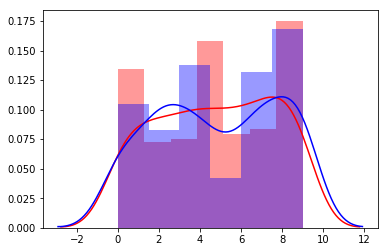

In [0]:
import seaborn as sns
ax1= sns.distplot(y_test,hist = True,color = 'r',label="actualvalues")
sns.distplot(rounded_pred,hist = True,color = 'b',label="predicted",ax=ax1)

# RESIZE FOR 3D 

In [0]:
X_train = np.resize(X_train,(2910,1300))
X_test = np.resize(X_test,(364,1300))
X_train = X_train.reshape((2910,50,26))
X_test  =X_test.reshape((364,50,26))


In [0]:
X_train = np.stack((X_train, X_train,X_train),axis=-1)
X_test = np.stack((X_test, X_test,X_test),axis=-1)

In [0]:
print(X_train.shape)

(2910, 50, 26, 3)


In [0]:
X_train, y_train, X_valid, y_valid = split(X_train, y_train, 0.9)

(3787, 35, 40, 3)


In [0]:
# For some reason
y_train = y_train.flatten()
y_test = y_test.flatten()

# Classification

# Convolution Network

In [0]:
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
y_train = y_train +10
y_test = y_test +10
y_train_b = keras.utils.to_categorical(y_train, 10)
y_test_b = keras.utils.to_categorical(y_test, 10)

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,26,3)))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'
                ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
print(y_train)

[12.  1.  7. ... 15. 12. 11.]


In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 24, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16192)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2072704   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 2,093,386
Trainable params: 2,093,386
Non-trainable params: 0
____________________________________________

In [0]:
from keras.optimizers import adam
op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train_b, epochs=60, batch_size=50, verbose =2, validation_split=0.1, callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Train on 2619 samples, validate on 291 samples
Epoch 1/60
 - 12s - loss: 2.3358 - acc: 0.1035 - val_loss: 2.3027 - val_acc: 0.0722
Epoch 2/60
 - 11s - loss: 2.3013 - acc: 0.1149 - val_loss: 2.3032 - val_acc: 0.0756
Epoch 3/60
 - 11s - loss: 2.2985 - acc: 0.1153 - val_loss: 2.3110 - val_acc: 0.0687
Epoch 4/60
 - 11s - loss: 2.2896 - acc: 0.1336 - val_loss: 2.3087 - val_acc: 0.0928
Epoch 5/60
 - 11s - loss: 2.2661 - acc: 0.1520 - val_loss: 2.4061 - val_acc: 0.0825
Epoch 6/60
 - 11s - loss: 2.2067 - acc: 0.2008 - val_loss: 2.3783 - val_acc: 0.1306


# RESNET Model

In [0]:
from keras import applications

base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (35,40,3))


W0827 06:55:38.923965 139926750480256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 06:55:38.966801 139926750480256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 06:55:38.988155 139926750480256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0827 06:55:39.036451 139926750480256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827 06:55:39.037693

94658560/94653016 [==============================] - 1s 0us/step


In [0]:
SHAPE = (28, 28, 1)

In [0]:
from keras import applications

from keras.layers import (Activation, BatchNormalization, Convolution2D, Dense,
                          Flatten, Input, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D,Dropout)
from keras.models import Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(10, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

W0827 06:56:05.409747 139926750480256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0827 06:56:05.410896 139926750480256 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
from keras.optimizers import adam
op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(optimizer=op, loss='sparse_categorical_crossentropy',metrics=['accuracy'])


W0827 06:56:10.798480 139926750480256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.fit(X_train, y_train, epochs=60, batch_size=50, verbose =2, validation_split=0.1)

W0827 06:56:14.049683 139926750480256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1309 samples, validate on 146 samples
Epoch 1/60
 - 171s - loss: 3.0351 - acc: 0.1115 - val_loss: 5.5508 - val_acc: 0.1164
Epoch 2/60
 - 160s - loss: 2.6329 - acc: 0.1215 - val_loss: 2.2903 - val_acc: 0.0822
Epoch 3/60
 - 161s - loss: 2.7433 - acc: 0.1207 - val_loss: 2.3034 - val_acc: 0.1370
Epoch 4/60
 - 164s - loss: 2.7860 - acc: 0.1230 - val_loss: 2.6885 - val_acc: 0.1096
Epoch 5/60
 - 166s - loss: 2.7264 - acc: 0.1131 - val_loss: 3.5943 - val_acc: 0.0685
Epoch 6/60
 - 166s - loss: 2.6771 - acc: 0.1054 - val_loss: 2.2650 - val_acc: 0.1233
Epoch 7/60
 - 166s - loss: 2.6083 - acc: 0.1062 - val_loss: 2.2894 - val_acc: 0.0753
Epoch 8/60
 - 164s - loss: 2.6016 - acc: 0.1222 - val_loss: 2.4911 - val_acc: 0.0616
Epoch 9/60
 - 166s - loss: 2.7027 - acc: 0.1291 - val_loss: 2.3045 - val_acc: 0.0685
Epoch 10/60
 - 163s - loss: 2.8793 - acc: 0.1161 - val_loss: 3.9520 - val_acc: 0.0822
Epoch 11/60
 - 166s - loss: 2.6756 - acc: 0.1054 - val_loss: 8.5479 - val_acc: 0.0959
Epoch 12/60
 - 1

KeyboardInterrupt: ignored

# Using VGG **Model**
loading the model


include_top (True): Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.

weights (‘imagenet‘): What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.

input_tensor (None): A new input layer if you intend to fit the model on new data of a different size.

input_shape (None): The size of images that the model is expected to take if you change the input layer.

classes (1000): The number of classes (e.g. size of output vector) for the model.


In [0]:
from keras import applications
# If you want to specify input tensor
from keras.layers import Input
input_tensor = Input(shape=(35, 40, 3))
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# To see the models' architecture and layer names, run the following
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 35, 40, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 35, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 35, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 17, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 17, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 17, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 10, 128)        0         
__________

create map to map each layer in vgg to name

In [0]:
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

print(layer_dict)

{'input_3': <keras.engine.input_layer.InputLayer object at 0x7f671dd2f470>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x7f671dd2f908>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x7f671dd1e198>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x7f671dc9f048>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x7f671dc7e978>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x7f671dc37198>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x7f671dc4a780>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x7f671dc4a8d0>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x7f671dbf95c0>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x7f671dc135f8>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x7f671dc23b00>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x7f671dbbe160>, 'block4_conv2': <keras.layers.convolutional.Conv2D object at 0x7f671d

In [0]:
from keras.layers import Dense, Activation, Flatten
# Getting output tensor of the last VGG layer that we want to include
x = Flatten()( layer_dict['block2_pool'].output)
x = Dense(256, activation='relu')(x)
x = Dense(26, activation='softmax')(x)
# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)
print(custom_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 35, 40, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 35, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 35, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 17, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 17, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 17, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 10, 128)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
from keras.optimizers import adam
op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
custom_model.compile(optimizer=op, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(X_train.shape)

(3787, 35, 40, 3)


In [0]:
custom_model.fit(X_train, y_train, epochs=60, batch_size=50, verbose =2, validation_split=0.1)

Train on 3408 samples, validate on 379 samples
Epoch 1/60
 - 68s - loss: 15.4854 - acc: 0.0358 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 2/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 3/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 4/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 5/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 6/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 7/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 8/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 9/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 10/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch 11/60
 - 67s - loss: 15.4938 - acc: 0.0387 - val_loss: 15.5652 - val_acc: 0.0343
Epoch

KeyboardInterrupt: ignored